# Applying OT-intNMF to PBMC

## Imports

In [31]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [32]:
# Plotting
import matplotlib.pyplot as plt

In [33]:
# Our packages
from scmiot import models, pl, tl

In [34]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [35]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

In [199]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

 10%|█         | 20/200 [16:29<2:28:24, 49.47s/it, loss=-163.68420858183572]


In [200]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

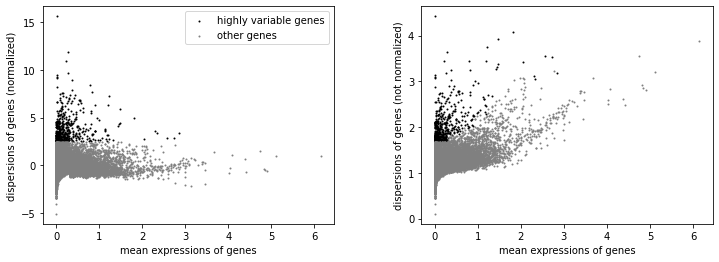

500

In [201]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=500)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

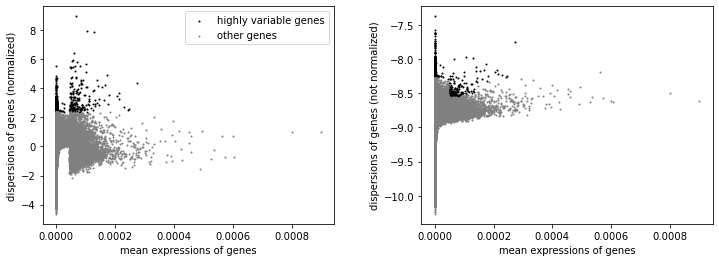

500

In [202]:
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7, n_top_genes=500)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

## Subsample

In [203]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

In [204]:
sc.pp.subsample(rna, n_obs=800, random_state=0)
sc.pp.subsample(atac, n_obs=800, random_state=0)

In [205]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [206]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 800 × 128106
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	800 x 22020
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	800 x 106086
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'hvg'

## OT-intNMF

### Train model

In [207]:
reload(models)

<module 'scmiot.models' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/models.py'>

In [226]:
# hyperparameters
eps = .075
latent_dim = 25
rho = .1

In [227]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho, rho_w=rho, eps=eps, cost='correlation')

In [228]:
nmf.fit_transform(mdata, max_iter_inner=1_000, max_iter=100, device='cpu', dtype=torch.double, lr=1e-1, tol_inner=1e-4, tol_outer=1e-3)

 19%|█▉        | 38/200 [02:41<05:20,  1.98s/it, loss=-463.81082190964054]

### Convergence plots

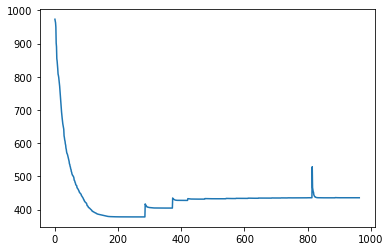

 19%|█▉        | 38/200 [02:41<11:27,  4.24s/it, loss=-463.81082190964054]


In [229]:
plt.plot(nmf.losses_h)

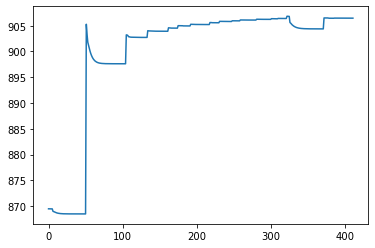

In [230]:
plt.plot(nmf.losses_w)

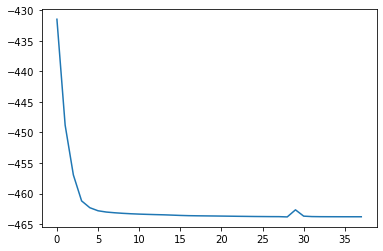

In [231]:
plt.plot(nmf.losses)

### Viz

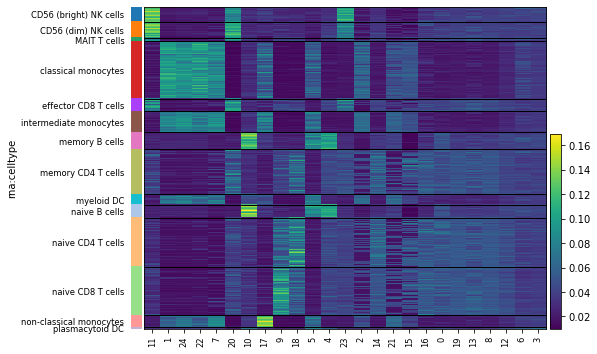

In [232]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

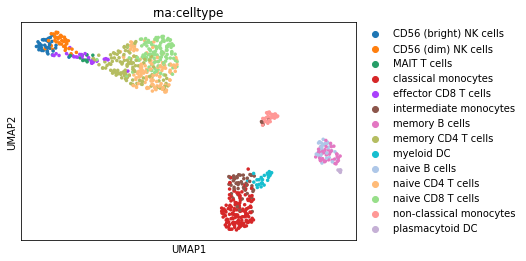

In [233]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Variance explained

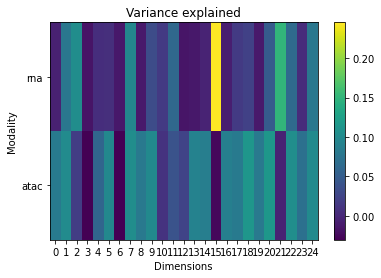

In [234]:
tl.variance_explained(mdata);